# Component Annihilation
The following note is a description of a method for component annihilation for stereo-panning estimation. In the following description, this method is described as a post-processing procedure. However, it is desirable to implement the functionality of this method as part of the likelihood-model in the segmentation algorithm and this still remains unsolved.

### Fitting a Gaussian mixture model to panning parameter space
The challenge of overfitting, a Gaussian mixture to the distribution space is amiguous. It is the case that both the MMDL, BIC and Varational Bayes will estimate a model order $k$ that is larger than the true order. However, the GMM-model is designed to describe every single data point as being part of a Gaussian distribution. The ambiguouity is that the overfitting of the Gaussian mixture model can be exploited as a parameter to utilize for initialization of the EM-algorithm, which is also the case for the MMDL <cite data-cite="granger2013">(Figuireido, 2002)</cite>.     

By starting with $k$, where $k$ is much larger than the true/optimal number of mixture components, the adopted algorithm is robust with respect to initialization of the EM-algorithm. The MMDL algorithm applies component annihilation, by adopting a Dirichlet prior on the mixing probabilities <cite data-cite="granger2013">(Figuireido, 2002)</cite>, and selects the number of components by annihilating the weakest component in the M-step of an iterative component-wise EM  ($\text{CEM}^2$) <cite data-cite="CEM2">( G. Celeux, S. Chreatien, F. Forbes, and A. Mkhadri, 1999)</cite>. This procedure leads to a smaller model order and still describes every data point as being part of a Gaussian distribution. It is important to notice that every true parameter is then described by at least one or more of the clusters, often more than one. 

### Clustering and component metrics
After model selection by the MMDL algorithm, each cluster is described by one or more components. Therefore, we have applied a post-processing step to select the correct number of clusters from prior spatial knowledge of the the conditional distributions. 
This post-processing step selects clusters from an analysis on each cluster covariance compared to the number of estimated points embedded in each cluster. We know from <cite data-cite="Rickardondisjoint">(Rickard and Yilmaz, 2002)</cite> that due to the non-disjoint spectral overlap of sources, the variance increases in the amplitude direction. Therefore, we propose to select clusters with largest amount estimated points, relative to the size of the respective covariance and its rotational angle in the parameter space. We describe this for the $k$th covariance $\mathbf{C}_k$ in the following. 

We define $\mathbf{C}_k$ geometrically as an ellipsoid by applying the singular value decomposition as,
\begin{equation}
\mathbf{C}_k = \mathbf{U} \mathbf{\Sigma} \mathbf{V}^T
\label{svd1}
\tag{svd1}
\end{equation}

Where  $\mathbf{U}$ and  $\mathbf{V}$ are orthonormal rotation matrices and the diagonal of $\mathbf{\Sigma}$ contains the principal axes $a^2$ and $b^2$. 

We compute the angle $\theta$ of the principal axes $a$ to the x-axis,

\begin{equation}
\theta = \tan{(\mathbf{u_{2}} / \mathbf{u_{1}})^{-1}}
\label{angle1}
\tag{angle1}
\end{equation}

we center $\mathbf{C}_k$ by subtracting the mean $\mathbf{\mu}_k$ as $\mathbf{d} = \mathbf{C}_k-\mathbf{\mu}_k$

The $x$ and $y$ coordinates of each estimate is given as,
\begin{equation}
(x, y) = (\mathbf{d}_1 \cos{\theta} + \mathbf{d}_2 \sin{\theta}, -\mathbf{d}_1 \sin{\theta} + \mathbf{d}_2 \cos{\theta})
\label{xy}
\tag{xy}
\end{equation}

We count the number of points inside cluster $k$. The specific point $(x,y)$ is inside the ellipse $k$ if,

\begin{equation}
\frac{x^2}{a_k^2} + \frac{y^2}{b_k^2} < 1
\label{elip}
\tag{elip}
\end{equation}

Lastly we compute the size of $\mathbf{C}_k$ as the determinant of $\mathbf{C}_k$ and we compute the "shadow" of the covariance on the x-axis as $s_k=a_k \cos{\theta_k} + b_k \sin{\theta_k}$. 

### Annihilation steps
The following component annihilation uses the cluster parameters from the MMDL and by comparing these to the data, the true clusters are selected and the rest of the data points will be removed. 
In the first implementation (post processing) we have two rules applied which is:

* If a cluster shares an estimated point with a smaller cluster, all points that is only part of the bigger cluster is removed. The overlapping bigger clusters are refered to as sticky clusters.
* A geometric threshhold is applied based on $\det(\mathbf{C}_k)$, the number of points embedded in $\mathbf{C}_k$  and the shadow $s$ on the x-axis.

### Thresholding on the cluster angle and size
We know from  <cite data-cite="Rickardondisjoint">(Rickard and Yilmaz, 2002) </cite> that spectral overlap causes larger variance in the amplitude direction, where optimally the covariance would be very small and diagonal or have greatest variance in the delay-direction. Therefore we can apply a threshhold from the rotation angle $\theta$ and the size of the region relative to the given number of estimates in the region.

We define a variable $0 \leq p_k \leq 1$ which is the percentage of points that is inside the $k$th cluster. We notice that the mixing parameter $\mathbf{\alpha}$ is proportional to $\frac{p}{\det(\mathbf{C})}$. We define a metric of peakiness $m$ for the $k$th source as,

\begin{equation}
m_k = \frac{p_k}{\det(\mathbf{C}_k) s_k}
\label{metric}
\tag{metric}
\end{equation}

where $s_k$ is the amplitude shadow, $s_k=a_k \cos{\theta_k} + b_k \sin{\theta_k}$. The metric $m_k$ carries implicit information of both the size and angle of the $k$th cluster region, that includes a percentage of all the estimated points (after sticky clusters have been removed).
From all metrics $\mathbf{m}$ we define a threshold where $m_k$ is relative to the smallest $m=m_1$. The metric ratio is,

\begin{equation}
ratio_k = \frac{m_k}{m_1}
\label{thr}
\tag{thr}
\end{equation}

Through experiments, we have found that this method of component annihilation has good performance for precisely estimating the number of sources in the mixture and the panning parameters. This is shown in the following simulation on some mixture of 7 sources from the SQAM-database.

#### Simulation in MATLAB
In the figure showing the parameter space it is clear that the covariance assumption desribed above holds and all 7 correct clusters have been estimated. The selected clusters are shown in color and the unselected clusters are shown in grey. The correct cluster covariances are either very small and close to diagonal or they are larger and have dominant variance mainly in the delay direction (upwards). We notice that the MMDL algorithm in this case chose a $k=18$. Notice that the 11 "wrong clusters" are large with random covariance structure and rotation angle.

The next figure shows the ratio function in (\ref{thr}). We note that between $k=7$ and $k=8$ there is a ratio difference on the order of $10^{18}$, which often is sufficient for a fixed threshold.

> In kmeans2/loopBody (line 183)
  In internal.stats.parallel.smartForReduce (line 136)
  In kmeans2 (line 53)
  In kmeans (line 314)
  In mixtures4_remove_outliers (line 113)
  In smc_GMM_MMDL_normdetC (line 16)
estimatedParam =
  -29.9942    6.0101
  -19.9993    4.0048
   -9.9693    3.0208
   -0.0075    0.0014
    9.9882   -3.0066
   20.0239   -4.0553
   30.0699   -6.1334


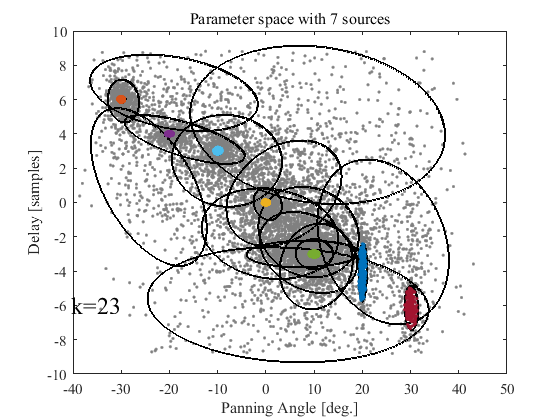

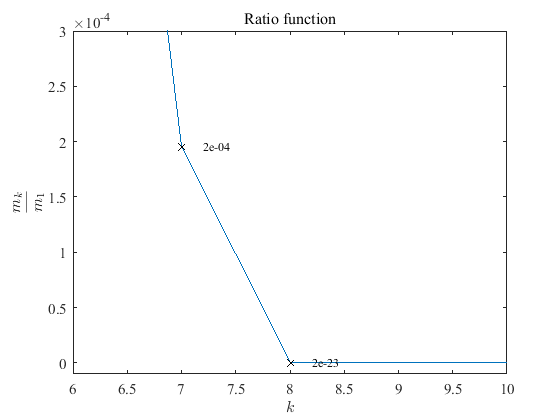

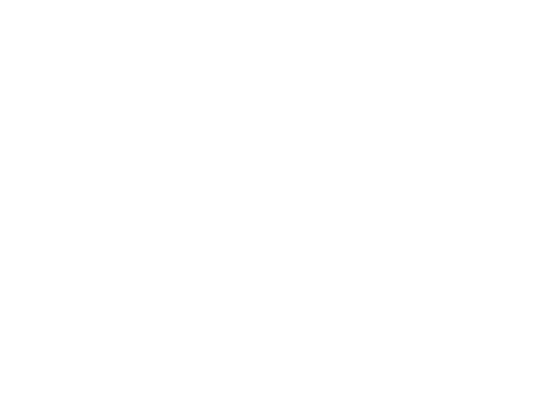

In [1]:
cd /home/jacob/panning_project/test_programs/;
load panning_data2.mat;
X = panning_data;
fs=44100;
trueNumClusters=7;
figure;
[~,~,~,~,~,~,~,~,estimatedParam,~,X2]  = ...
smc_GMM_MMDL_normdetC(X.*[1/45 1/(150e-6*fs)], fs,trueNumClusters);
xlabel('Panning Angle [deg.]'); ylabel('Delay [samples]'); 
title('Parameter space with 7 sources');

estimatedParam

We run the same algorithm on 3 parameter spaces with mixtures made from the SQAM audio. 

trueParam =
   32.5000   -1.0000
   30.0000   -4.0000
  -30.0000    3.0000
estimatedParam =
  -29.9591    2.9981
   29.9972   -4.0038
   32.4922   -0.9976


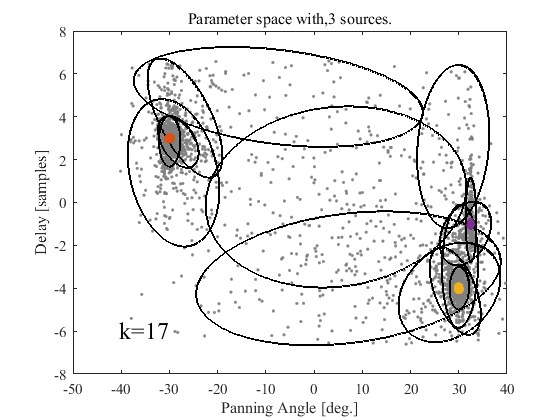

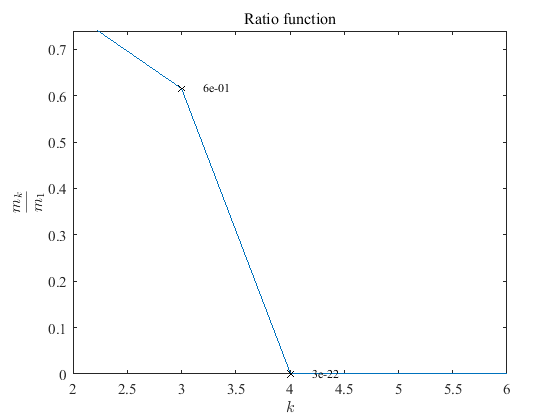

In [2]:
clear all;
cd /home/jacob/panning_project/test_programs/;
load test_covration_100iter_notoptimal16april.mat
index=randi(100);
X=savedX{index};
[~,~,~,~,~,~,~,~,estimatedParam,~,X2]  = ...
smc_GMM_MMDL_normdetC(X, fs,size(true(index).Points,1));
xlabel('Panning Angle [deg.]'); ylabel('Delay [samples]'); 
title(strcat('Parameter space with, ', sprintf('%1.0f',size(true(index).Points,1)), ' sources.'));
trueParam = true(index).Points
estimatedParam

trueParam =
   37.5000   -5.0000
    5.0000   -1.0000
  -37.5000    3.0000
   -5.0000    4.0000
estimatedParam =
  -37.5622    3.0013
   -4.8934    3.9880
    4.9929   -1.0039
   37.4738   -4.5625


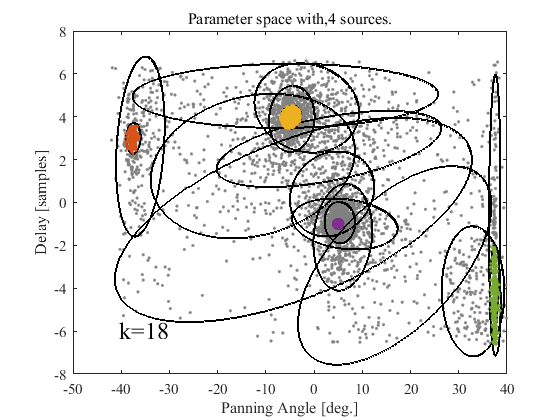

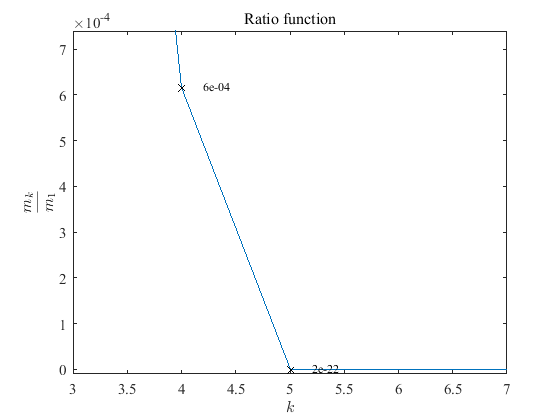

In [3]:
clear all;
cd /home/jacob/panning_project/test_programs/;
load test_covration_100iter_notoptimal16april.mat
index=randi(100);
X=savedX{index};
[~,~,~,~,~,~,~,~,estimatedParam,~,X2]  = ...
smc_GMM_MMDL_normdetC(X, fs,size(true(index).Points,1));
xlabel('Panning Angle [deg.]'); ylabel('Delay [samples]'); 
title(strcat('Parameter space with, ', sprintf('%1.0f',size(true(index).Points,1)), ' sources.'));
trueParam = true(index).Points
estimatedParam

> In kmeans2/loopBody (line 183)
  In internal.stats.parallel.smartForReduce (line 136)
  In kmeans2 (line 53)
  In kmeans (line 314)
  In mixtures4_remove_outliers (line 113)
  In smc_GMM_MMDL_normdetC (line 16)
trueParam =
   10.0000   -6.0000
   32.5000   -2.0000
  -32.5000    2.0000
estimatedParam =
  -32.5053    1.9984
   10.0131   -6.0106
   32.5140   -2.0014


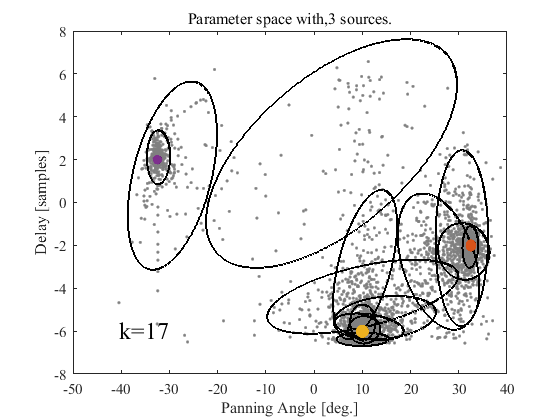

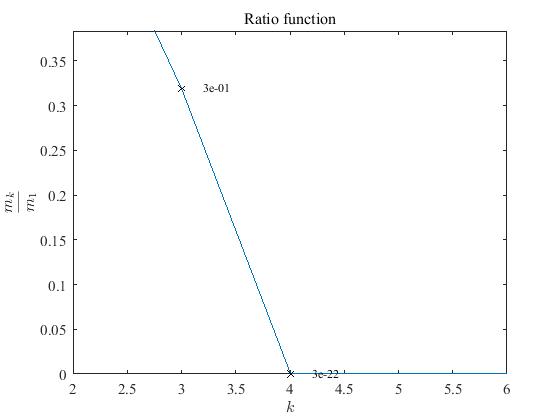

In [4]:
clear all;
cd /home/jacob/panning_project/test_programs/;
load test_covration_100iter_notoptimal16april.mat
index=randi(100);
X=savedX{index};
[~,~,~,~,~,~,~,~,estimatedParam,~,X2]  = ...
smc_GMM_MMDL_normdetC(X, fs,size(true(index).Points,1));
xlabel('Panning Angle [deg.]'); ylabel('Delay [samples]'); 
title(strcat('Parameter space with, ', sprintf('%1.0f',size(true(index).Points,1)), ' sources.'));
trueParam = true(index).Points
estimatedParam